# GPAO I
 Throughout the M\"uller Brown example, we are going to manually perform one image method (OIM) (https://aip.scitation.org/doi/10.1063/1.4986787). Where we optimize the pathway using minimum calculation of actual potential.


## Previously on Muller Brown II



In [1]:
import numpy as np
from taps.paths import Paths
from taps.models import MullerBrown
from taps.coords import Cartesian
from taps.visualize import view

from taps.projectors import Sine
# We are going to use only the 30% of the coordinate information

N = 300

x = np.linspace(-0.55822365, 0.6234994, N)
y = np.linspace(1.44172582, 0.02803776, N)

coords = Cartesian(coords=np.array([x, y]))

Nk = N - 270
prj = Sine(N=N, Nk=Nk, 
           init=coords.coords[..., 0].copy(), 
           fin=coords.coords[..., -1].copy())

from taps.pathfinder import DAO

action_kwargs = {
    'Onsager Machlup':{    
        'gam': 1.,
    },
    'Energy Restraint':{
        'muE': 1.,
        'Et': -0.45
    }
}

search_kwargs = {"method":"L-BFGS-B"}

finder = DAO(action_kwargs=action_kwargs,
             search_kwargs=search_kwargs, 
             prj=prj)

from taps.db import ImageDatabase
imgdata = ImageDatabase(filename="mullerbrown.db")


from taps.models import Gaussian

model = MullerBrown()
model = Gaussian(real_model=model)

paths = Paths(coords=coords, model=model, finder=finder, imgdata=imgdata)

bounds = np.array([[1e-2, 5e1],   # sigma_f': 0
                    [1e-2, 1e2],   # l^2': 1
                    [1e-5, 1e-2],  # sigma_n^e': 2
                    [1e-6, 1e-3]])# sigma_n^f': 3
paths.model.regression.kernel_regression_kwargs['method'] = 'L-BFGS-B'
paths.model.regression.kernel_regression_kwargs['bounds'] = bounds

paths.add_data(index=[0, coords.N//3, -1])

paths.search()


      Parameters
Onsager Machlup
  gam        : 1.0  
 
Energy Restraint
  muE        : 1.0  
  Et         : -0.45
 
            Iter   nfev   njev        S   dS_max
Converge :    141    149    149  20.3140   0.0066
Converge :    145    156    156  20.3140   0.0014
Converge :    147    161    161  20.3140   0.0010
sigma_f    : 0.4766740676976387
l^2        : 0.11361957790782236
sigma_n^e  : 0.01
sigma_n^f  : 1e-06
            Results
 Onsager Machlup             : 1.7697186473566024
 Energy Restraint            : 18.544244264193537
 Total S                     : 20.31396291155014


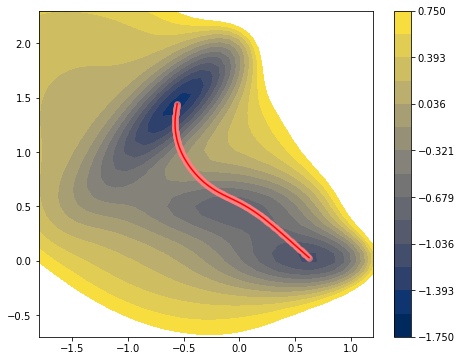

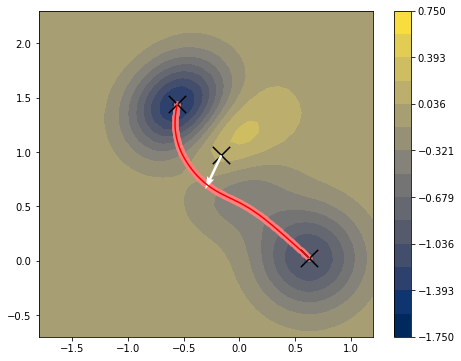

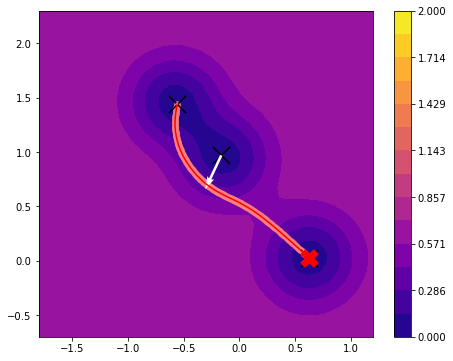

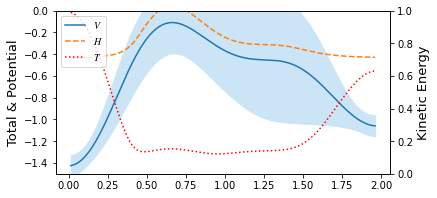

In [2]:
view(paths, viewer='MullerBrown', gaussian=True)

In [3]:
paths.model.kernel.hyperparameters

{'sigma_f': 0.4766740676976387,
 'l^2': 0.11361957790782236,
 'sigma_n^e': 0.01,
 'sigma_n^f': 1e-06}

## One Image Method

Process of OIM is following 
1. Optimization on Gaussian PES
2. Add data having maximum uncertainty

      Parameters
Onsager Machlup
  gam        : 1.0  
 
Energy Restraint
  muE        : 1.0  
  Et         : -0.45
 
            Iter   nfev   njev        S   dS_max
Converge :    388    416    416  12.4360   0.0052
Converge :    390    421    421  12.4360   0.0011
sigma_f    : 0.4480467348659725
l^2        : 0.13899338637254355
sigma_n^e  : 0.01
sigma_n^f  : 1e-06
            Results
 Onsager Machlup             : 1.9123097395809385
 Energy Restraint            : 10.523648990483148
 Total S                     : 12.435958730064087


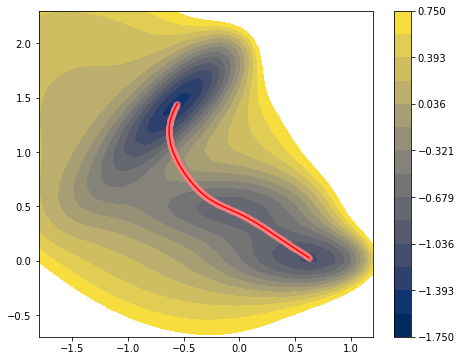

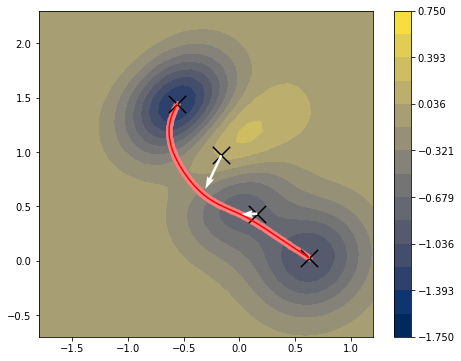

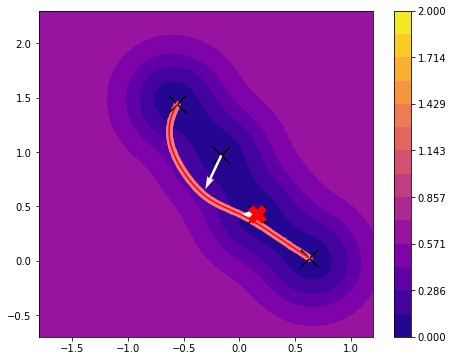

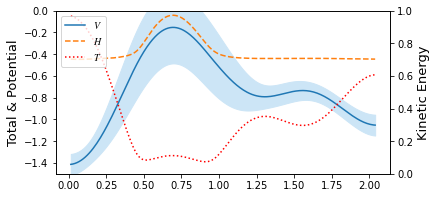

In [4]:
most_uncertain_idx = np.argmax(paths.get_covariance())
paths.add_data(index=[most_uncertain_idx])
paths.search()
view(paths, viewer='MullerBrown', gaussian=True)

In [5]:
paths.get_image_data()['coords'].shape

(2, 4)

      Parameters
Onsager Machlup
  gam        : 1.0  
 
Energy Restraint
  muE        : 1.0  
  Et         : -0.45
 
            Iter   nfev   njev        S   dS_max
Converge :    577    620    620   4.1117   0.0004
Converge :    578    624    624   4.1117   0.0008
sigma_f    : 0.41248396030909457
l^2        : 0.13946623807497205
sigma_n^e  : 0.01
sigma_n^f  : 1e-06
            Results
 Onsager Machlup             : 1.3583751308047698
 Energy Restraint            : 2.7533322350590037
 Total S                     : 4.111707365863774


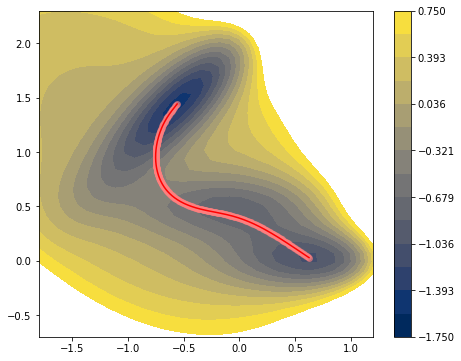

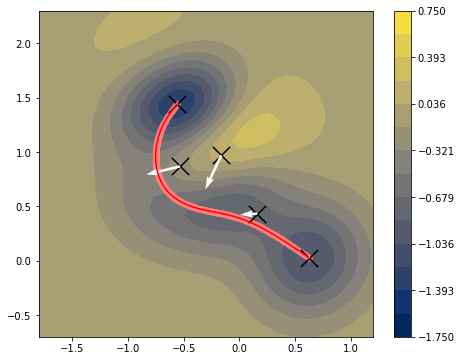

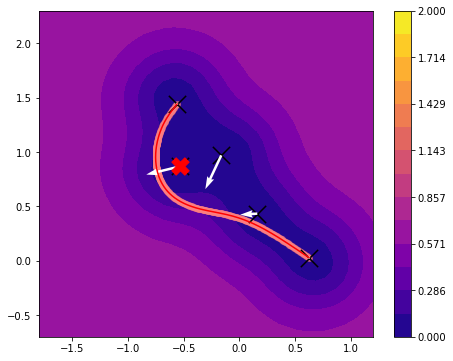

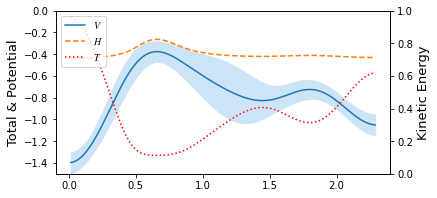

In [6]:
most_uncertain_idx = np.argmax(paths.get_covariance())
paths.add_data(index=[most_uncertain_idx])
paths.search()
view(paths, viewer='MullerBrown', gaussian=True)

      Parameters
Onsager Machlup
  gam        : 1.0  
 
Energy Restraint
  muE        : 1.0  
  Et         : -0.45
 
            Iter   nfev   njev        S   dS_max
Converge :    705    760    760   4.2425   0.0016
Converge :    708    766    766   4.2425   0.0010
sigma_f    : 0.42217063088868156
l^2        : 0.14765245449874476
sigma_n^e  : 1e-05
sigma_n^f  : 1e-06
            Results
 Onsager Machlup             : 1.393211233362372
 Energy Restraint            : 2.84929155154869
 Total S                     : 4.242502784911062


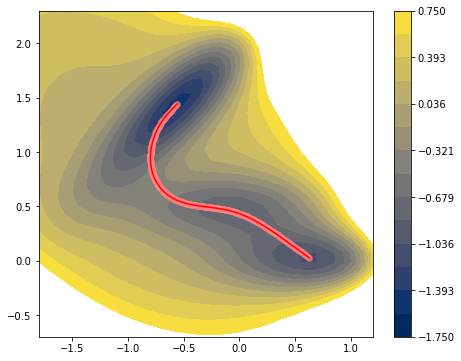

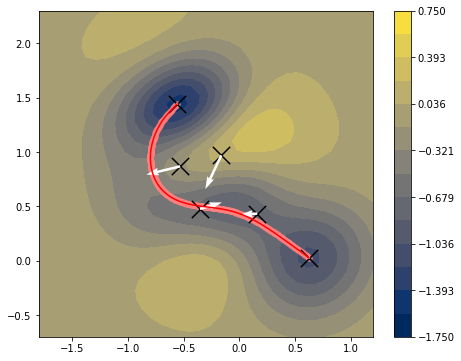

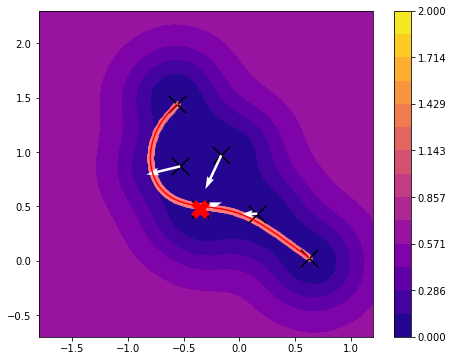

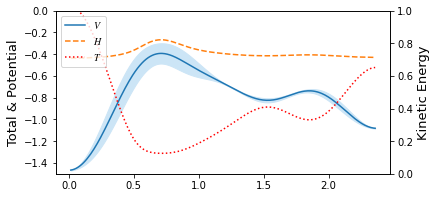

In [7]:
most_uncertain_idx = np.argmax(paths.get_covariance())
paths.add_data(index=[most_uncertain_idx])
paths.search()
view(paths, viewer='MullerBrown', gaussian=True)

      Parameters
Onsager Machlup
  gam        : 1.0  
 
Energy Restraint
  muE        : 1.0  
  Et         : -0.45
 
            Iter   nfev   njev        S   dS_max
Converge :    873    941    941   3.0527   0.0005
Converge :    874    945    945   3.0527   0.0005
sigma_f    : 0.42743179615195126
l^2        : 0.15088012292915423
sigma_n^e  : 0.008008019586854749
sigma_n^f  : 1e-06
            Results
 Onsager Machlup             : 1.3928120267583888
 Energy Restraint            : 1.6599179534708568
 Total S                     : 3.0527299802292456


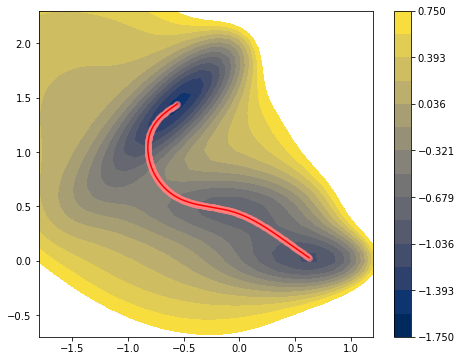

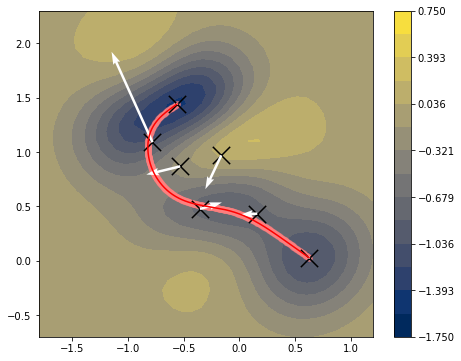

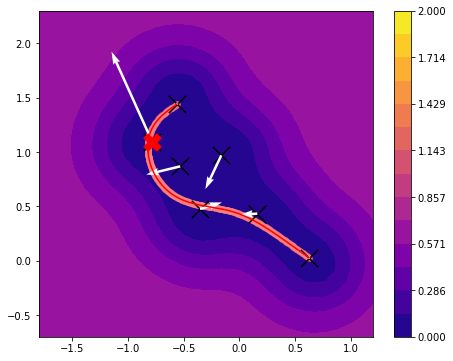

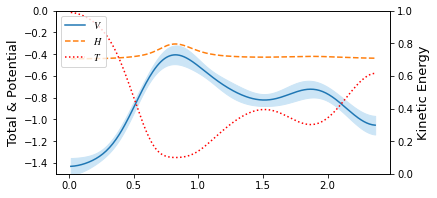

In [8]:
most_uncertain_idx = np.argmax(paths.get_covariance())
paths.add_data(index=[most_uncertain_idx])
paths.search()
view(paths, viewer='MullerBrown', gaussian=True)

      Parameters
Onsager Machlup
  gam        : 1.0  
 
Energy Restraint
  muE        : 1.0  
  Et         : -0.45
 
            Iter   nfev   njev        S   dS_max
Converge :   1026   1108   1108   3.0644   0.0005
Converge :   1027   1112   1112   3.0644   0.0005
sigma_f    : 0.42204256571174864
l^2        : 0.15559626894003398
sigma_n^e  : 0.005352694642457148
sigma_n^f  : 1e-06
            Results
 Onsager Machlup             : 1.3654528398128043
 Energy Restraint            : 1.6989615910581048
 Total S                     : 3.064414430870909


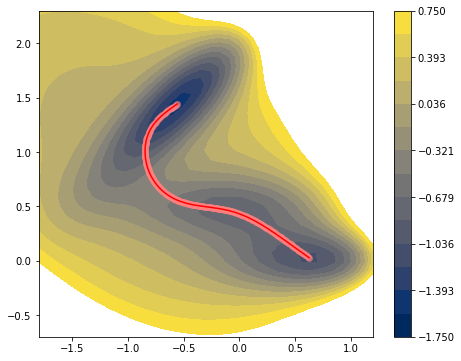

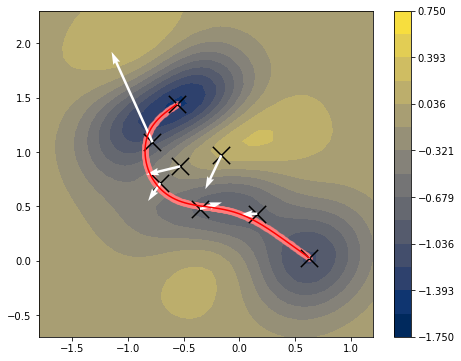

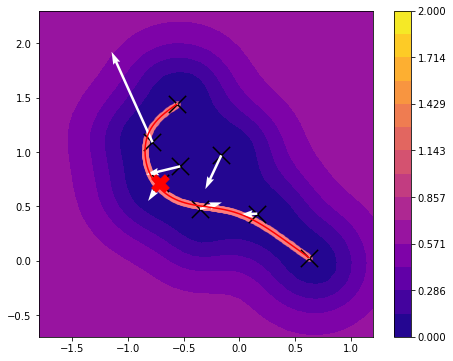

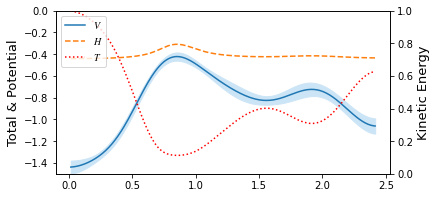

In [9]:
most_uncertain_idx = np.argmax(paths.get_covariance())
paths.add_data(index=[most_uncertain_idx])
paths.search()
view(paths, viewer='MullerBrown', gaussian=True)

      Parameters
Onsager Machlup
  gam        : 1.0  
 
Energy Restraint
  muE        : 1.0  
  Et         : -0.45
 
            Iter   nfev   njev        S   dS_max
Converge :   1028   1116   1116   3.0644   0.0004
sigma_f    : 0.4220425630593123
l^2        : 0.155596279780426
sigma_n^e  : 0.005352694411810509
sigma_n^f  : 1e-06
            Results
 Onsager Machlup             : 1.3654525037730145
 Energy Restraint            : 1.6989606903274068
 Total S                     : 3.064413194100421


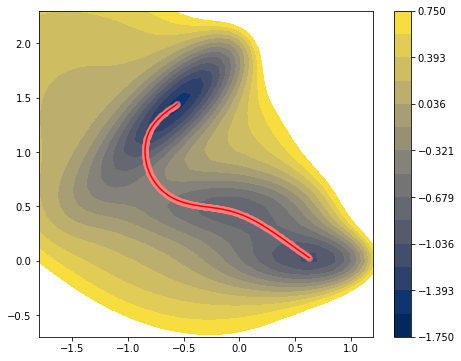

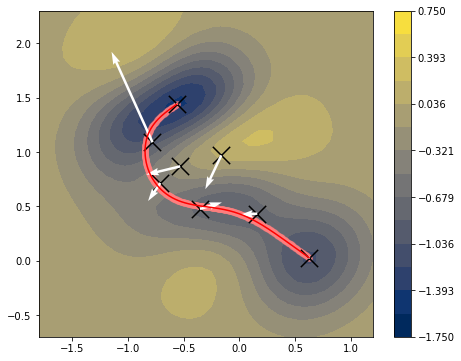

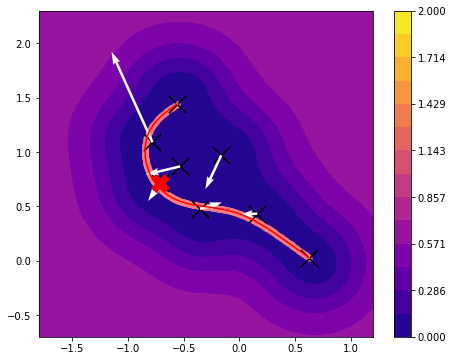

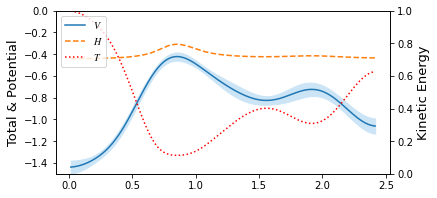

In [10]:
most_uncertain_idx = np.argmax(paths.get_covariance())
paths.add_data(index=[most_uncertain_idx])
paths.search()
view(paths, viewer='MullerBrown', gaussian=True)

      Parameters
Onsager Machlup
  gam        : 1.0  
 
Energy Restraint
  muE        : 1.0  
  Et         : -0.45
 
            Iter   nfev   njev        S   dS_max
Converge :   1029   1120   1120   3.0644   0.0004
sigma_f    : 0.4220425629676087
l^2        : 0.15559627956910907
sigma_n^e  : 0.0053526949939288445
sigma_n^f  : 1e-06
            Results
 Onsager Machlup             : 1.3654524686937977
 Energy Restraint            : 1.6989607538832843
 Total S                     : 3.064413222577082


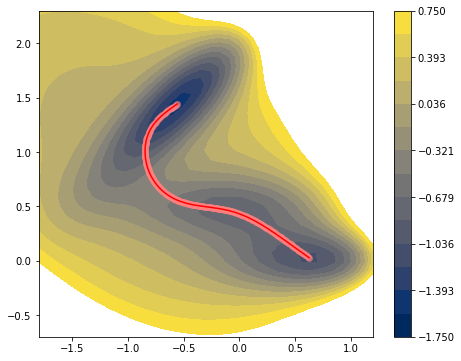

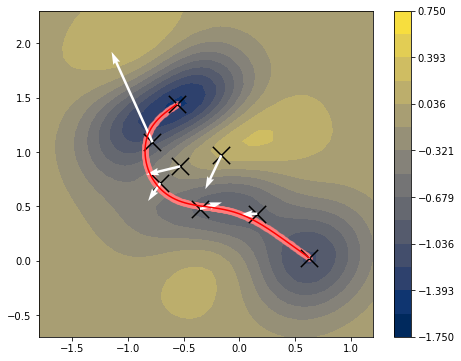

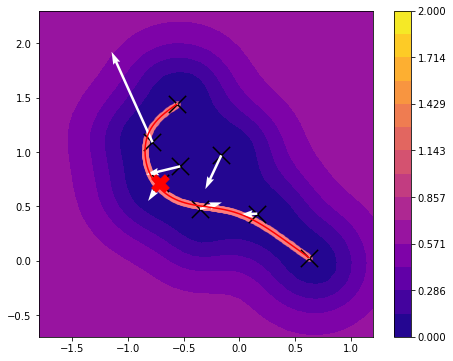

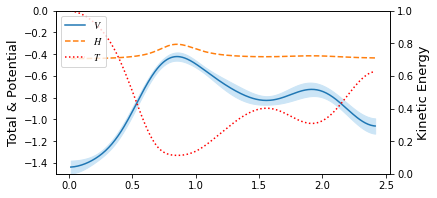

In [11]:
most_uncertain_idx = np.argmax(paths.get_covariance())
paths.add_data(index=[most_uncertain_idx])
paths.search()
view(paths, viewer='MullerBrown', gaussian=True)

      Parameters
Onsager Machlup
  gam        : 1.0  
 
Energy Restraint
  muE        : 1.0  
  Et         : -0.45
 
            Iter   nfev   njev        S   dS_max
Converge :   1030   1124   1124   3.0644   0.0003
sigma_f    : 0.4220425629676087
l^2        : 0.15559627956910907
sigma_n^e  : 0.0053526949939288445
sigma_n^f  : 1e-06
            Results
 Onsager Machlup             : 1.3654524325383772
 Energy Restraint            : 1.6989607890864602
 Total S                     : 3.0644132216248376


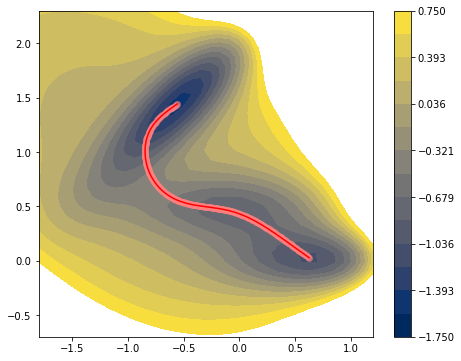

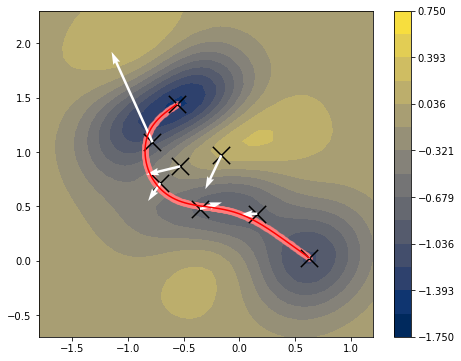

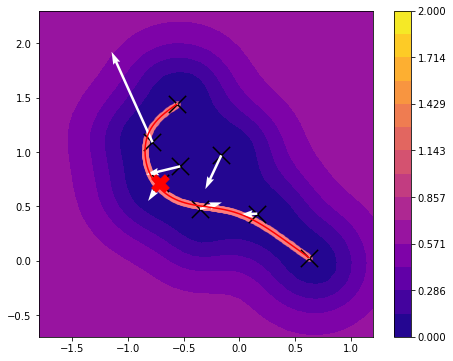

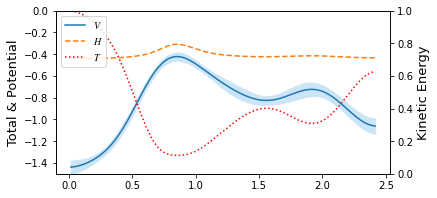

In [12]:
most_uncertain_idx = np.argmax(paths.get_covariance())
paths.add_data(index=[most_uncertain_idx])
paths.search()
view(paths, viewer='MullerBrown', gaussian=True)

      Parameters
Onsager Machlup
  gam        : 1.0  
 
Energy Restraint
  muE        : 1.0  
  Et         : -0.45
 
            Iter   nfev   njev        S   dS_max
Converge :   1046   1144   1144   3.0644   0.0044
Converge :   1047   1149   1149   3.0644   0.0044
sigma_f    : 0.4220425629676087
l^2        : 0.15559627956910907
sigma_n^e  : 0.0053526949939288445
sigma_n^f  : 1e-06
            Results
 Onsager Machlup             : 1.3654524033432558
 Energy Restraint            : 1.6989586616640489
 Total S                     : 3.0644110650073046


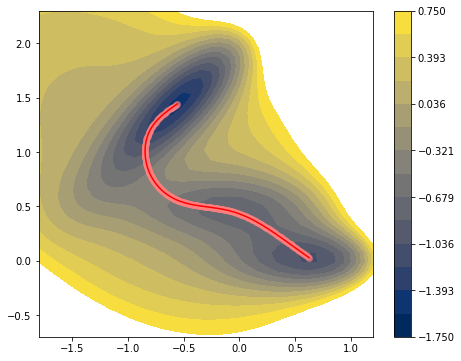

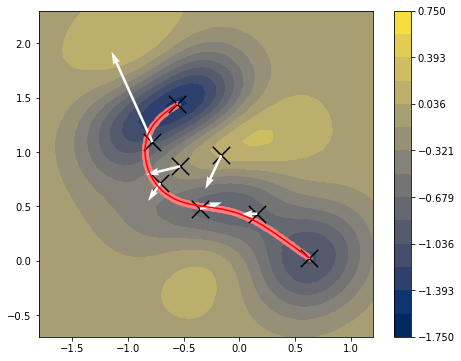

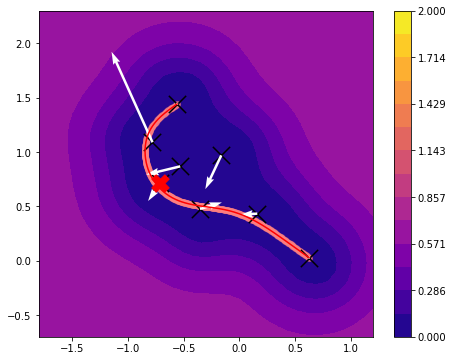

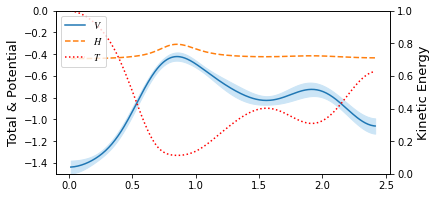

In [13]:
paths.finder.real_finder.prj.Nk = N - 2
most_uncertain_idx = np.argmax(paths.get_covariance())
paths.add_data(index=[most_uncertain_idx])
paths.search()
view(paths, viewer='MullerBrown', gaussian=True)

You can see the process of pathway being optimized throughout iteration. 